In [14]:
import os
import gc
import sys
import pickle
import logging

# Data manipulation imports
import pandas as pd
import polars as pl

# pycisTopic imports
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments, merge
from pycisTopic.qc import get_barcodes_passing_qc_for_sample

import matplotlib.pyplot as plt
import scrublet as scr
import subprocess

from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('PROJECT_FUNCTIONS_PATH'))

from grn_helpers import set_output_folders, select_files

# %% # Load environment variables
root_dir = os.getenv('BASE_PATH')

# %% # Define parameters
n_cpu = 16
neurons_set = "L2-3_CUX2"
# neurons_set = "all_ex"
# neurons_set = "all_ex_all_ages"

# %% # Define parameters
cells_dict = {
    "all_ex"            :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev'],
    "all_ex_all_ages"   :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev'],
    "L2-3_CUX2"         :   ['L2-3_CUX2']
}

ages_dict = {
    "all_ex"           :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_ex_all_ages"  :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24'],
    "L2-3_CUX2"        :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24']
}

out_dir, in_dir, root_dir, tmp_dir, data_folder = set_output_folders(root_dir, neurons_set)
sel_celltypes = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

root_dir: /group/testa/michal.kubacki/herring_minimal
out_dir: /group/testa/michal.kubacki/herring_minimal/L2-3_CUX2
in_dir: /group/testa/michal.kubacki/herring_minimal/data
tmp_dir: /group/testa/michal.kubacki/herring_minimal/tmp


In [16]:
def process_age(name):
    parts = name.split('-')[1]
    processed_name = parts.split('_')[1]
    return processed_name

def process_name(name):
    parts = name.split('_')[:2]
    processed_name = '_'.join(parts)
    processed_name = processed_name.replace('/', '-')
    return processed_name

def process_chem(name):
    processed_name = name.split('_')[-1]
    return processed_name

def map_major_clust(name, mapped_names):
    for prefix, name_list in mapped_names.items():
        if name in name_list:
            return prefix
    return process_name(name)

# %% # format indexes
def format_index(index):
    parts = index.split("#")
    formatted_index = parts[1]
    return formatted_index

In [17]:
# %% # Load ATAC metadata
ATAC_metadata_path = os.path.join(in_dir, "Processed_data_ATAC_BCs-meta-data.csv")

# %% # load fragments data
fragments_dict = select_files(root_dir, selected_fragments = sel_ages)

# %% # load cells data
cells_data = pd.read_csv(ATAC_metadata_path, sep=",", index_col=0)

All fragments: {'ga22': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138510_RL2366_ga22_snATAC_fragments.tsv.gz', '1y': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138526_RL2209_1y_snATAC_fragments.tsv.gz', '14y': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138542_RL2372_14y_snATAC_fragments.tsv.gz', 'ga24': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138512_RL2207_ga24_snATAC_fragments.tsv.gz', '2y': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138529_RL1784_2y_snATAC_fragments.tsv.gz', '16y': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138544_RL1785_16y_snATAC_fragments.tsv.gz', '1m': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138515_RL2367_1m_snATAC_fragments.tsv.gz', '4y': '/group/testa/michal.kubacki/herring_minimal/data/GSE168408_RAW/GSM5138532_RL2210_4y_snATAC_fragments.tsv.gz', '20y': '/group/testa/michal.kubacki/

In [18]:
cells_data['age'] = cells_data.predictedCell.apply(process_age)
cells_data['chem'] = cells_data.predictedCell.apply(process_chem)

unique_names = cells_data.predictedGroup.unique()

prefixes = sel_celltypes
mapped_names = {}

for prefix in prefixes:
    mapped_names[prefix] = []
    for name in unique_names:
        if name.startswith(prefix):
            mapped_names[prefix].append(name)

cells_data['major_clust'] = cells_data.predictedGroup.apply(lambda x: map_major_clust(x, mapped_names))

In [19]:
# %% # mapping ages
mapping = {
    '2d': '1m',
    '34d': '1m',
    '86d': '3m',
    '118d': '3m',
    '179d': '6m',
    '301d': '10m',
    '422d': '1y',
    '2yr': '2y',
    '627d': '2y',
    '3yr': '4y',
    '4yr': '4y',
    '6yr': '6y',
    '8yr': '8y',
    '10yr': '10y',
    '12yr': '14y',
    '14yr': '14y',
    '16yr': '16y',
    '17yr': '16y',
    '20yr': '20y',
    '25yr': '25y',
    '40yr': '40y',
    'ga22': 'ga22',
    'ga24': 'ga24',
    'ga34': 'ga24'
}

cells_data["age_mapped"] = [mapping.get(age, age) for age in cells_data.age]
cells_data["age_mapped"].unique()

array(['3m', 'ga24', '6m', 'ga22', '1m', '10m', '2y', '16y', '4y', '1y',
       '20y', '6y', '14y', '40y', '25y', '10y', '8y'], dtype=object)

In [20]:
# %% # filter cells data
print(cells_data.shape)

cells_data = cells_data[cells_data['major_clust'].isin(sel_celltypes)]
print(cells_data.shape)

print(cells_data['chem'].value_counts())
print(cells_data['PassQC'].value_counts())

cells_data = cells_data[cells_data['chem']=="v3"]
print(cells_data.shape)

cells_data = cells_data[cells_data['age_mapped'].isin(sel_ages)]
print(cells_data.shape)

(87339, 24)
(7965, 24)
chem
v3    7371
v2     594
Name: count, dtype: int64
PassQC
1.0    7965
Name: count, dtype: int64
(7371, 24)
(6355, 24)


In [21]:
cells_data = cells_data.rename(index=format_index)

cells_data["old_index"] = cells_data.index
cells_data.index = cells_data.index + "-" + cells_data["age_mapped"]
cells_data = cells_data[cells_data.age_mapped.isin(fragments_dict)]

In [22]:
print(cells_data.shape)

(6355, 25)


In [23]:
for cell in cells_data['major_clust'].unique():
    print(f"{cell}: {(cells_data['major_clust']==cell).sum()}")

# %% # Create a dictionary to store the count of each cell type
cell_counts = {}

# Count the occurrences of each cell type
for cell in cells_data['major_clust'].unique():
    count = (cells_data['major_clust'] == cell).sum()
    cell_counts[cell] = count
    print(f"{cell}: {count}")

L2-3_CUX2: 6355
L2-3_CUX2: 6355


In [24]:
# Create a mask to filter cell types with count >= 1000
mask = cells_data['major_clust'].isin([cell for cell, count in cell_counts.items() if count >= 800])

# Subset cells_data based on the mask
cells_data = cells_data[mask]

# %% # print cell counts
for cell in cells_data['major_clust'].unique():
    print(f"{cell}: {(cells_data['major_clust']==cell).sum()}")

# cells_data = pd.read_csv(os.path.join(out_dir, 'cells_data.csv'), index_col = 0)
cells_data.head()

# %% # load chromsizes
chromsizes = pd.read_table(
    os.path.join(in_dir, f"hg19.chrom.sizes"),
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
 
# %% # collect garbage
gc.collect()

L2-3_CUX2: 6355


582

In [11]:
# %% # create output folders
os.makedirs(os.path.join(out_dir, "consensus_peak_calling"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"), exist_ok = True)

In [ ]:
# %% # export pseudobulk profiles
# beforehand one might need to run `for file in *fragments.tsv.gz; do tabix -p bed "$file"; done`
paths = export_pseudobulk(
    input_data = cells_data,
    variable = "major_clust",
    sample_id_col = "age_mapped",
    chromsizes = chromsizes,
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 32,
    temp_dir = '/home/michal.kubacki/Githubs/GeneScore/tmp',
    split_pattern = "-"
)

# %% # create bed paths
bw_paths, bed_paths = paths

with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        f.write(f"{v}\t{bed_paths[v]}\n")

# %% # infer consensus peaks
bed_paths = {}
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv")) as f:
    for line in f:
        v, p = line.strip().split("\t")
        bed_paths.update({v: p})

In [27]:
bed_paths

{'L2-3_CUX2': '/group/testa/michal.kubacki/herring_minimal/L2-3_CUX2/consensus_peak_calling/pseudobulk_bed_files/L2-3_CUX2.fragments.tsv.gz'}

In [ ]:
#%% # peak_calling
macs_path = "/home/michal.kubacki/.conda/envs/scenicplus/bin/macs2" 
os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok=True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(out_dir, "consensus_peak_calling/MACS"),
    genome_size = 'hs',
    n_cpu = 1,
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.05,
    _temp_dir = '/tmp',
    skip_empty_peaks=True,
    logging_level=logging.DEBUG
)

In [30]:
# load back saved results and examine narrowPeak file format
narrow_peak_dict = {}
for cell_type in bed_paths.keys():
    narrow_peak_dict[cell_type] = os.path.join(out_dir, f"consensus_peak_calling/MACS/{cell_type}_peaks.narrowPeak")

# Print description and example of narrowPeak format
print("MACS2 narrowPeak file format contains:")
print("1. chrom - chromosome name")
print("2. chromStart - start position") 
print("3. chromEnd - end position")
print("4. name - name of the peak")
print("5. score - integer score for display")
print("6. strand - +/- direction")
print("7. signalValue - measurement of overall enrichment")
print("8. pValue - -log10 p-value")
print("9. qValue - -log10 q-value")
print("10. peak - peak summit position relative to chromStart")

# Print first few lines of the narrowPeak file for L2-3_CUX2
print("\nExample lines from L2-3_CUX2_peaks.narrowPeak:")
peak_file = narrow_peak_dict['L2-3_CUX2']
with open(peak_file, 'r') as f:
    for i, line in enumerate(f):
        if i < 3:  # Print first 3 lines
            print(line.strip())

narrow_peak_dict

MACS2 narrowPeak file format contains:
1. chrom - chromosome name
2. chromStart - start position
3. chromEnd - end position
4. name - name of the peak
5. score - integer score for display
6. strand - +/- direction
7. signalValue - measurement of overall enrichment
8. pValue - -log10 p-value
9. qValue - -log10 q-value
10. peak - peak summit position relative to chromStart

Example lines from L2-3_CUX2_peaks.narrowPeak:
chr1	565288	565739	L2-3_CUX2_peak_1	888	.	30.7308	93.172	88.8254	43
chr1	710110	710277	L2-3_CUX2_peak_2	32	.	3.9511	5.09785	3.23527	73
chr1	713779	714674	L2-3_CUX2_peak_3	323	.	14.9264	35.3887	32.3176	269


{'L2-3_CUX2': '/group/testa/michal.kubacki/herring_minimal/L2-3_CUX2/consensus_peak_calling/MACS/L2-3_CUX2_peaks.narrowPeak'}

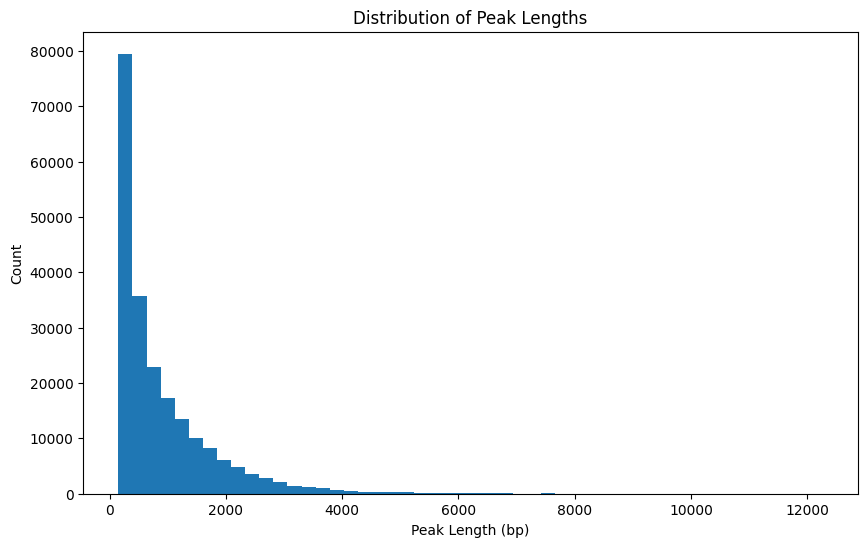

In [31]:
# Load peaks into dataframe to analyze lengths
peak_df = pd.read_csv(narrow_peak_dict['L2-3_CUX2'], sep='\t', header=None)
peak_df.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']

# Calculate peak lengths
peak_lengths = peak_df['end'] - peak_df['start']

# Create histogram of peak lengths
plt.figure(figsize=(10,6))
plt.hist(peak_lengths, bins=50)
plt.xlabel('Peak Length (bp)')
plt.ylabel('Count')
plt.title('Distribution of Peak Lengths')
plt.show()

In [ ]:
# %% # get consensus peaks
peak_half_width = 250
path_to_blacklist = os.path.join(in_dir, "hg19-blacklist.v2.bed")
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict=narrow_peak_dict,
    peak_half_width=peak_half_width,
    chromsizes=chromsizes,
    path_to_blacklist=path_to_blacklist)

# Pre-compute column types and optimize DataFrame operations
df = consensus_peaks.df

# Create a mask for object columns to avoid repeated dtype checks
object_cols = df.select_dtypes(include=['object']).columns

In [ ]:
# Process all columns in one pass using vectorized operations where possible
for col in object_cols:
    # Check if first non-null value is a set
    first_valid = df[col].first_valid_index()
    if first_valid is not None and isinstance(df.at[first_valid, col], set):
        df[col] = df[col].apply(list)
    else:
        # Use vectorized operation for checking sets in column
        has_sets = df[col].apply(lambda x: isinstance(x, set) if pd.notnull(x) else False).any()
        if has_sets:
            df[col] = df[col].apply(lambda x: list(x) if isinstance(x, set) else x)

# Process list columns more efficiently
list_columns = ['Name', 'Score', 'Strand', 'ThickStart', 'ThickEnd', 'ItemRGB', 'BlockCount', 'BlockSizes', 'BlockStarts']
list_cols_present = [col for col in list_columns if col in df.columns]

In [ ]:
if list_cols_present:
    for col in list_cols_present:
        df[col] = df[col].apply(lambda x: [] if pd.isna(x) else (
            list(x) if isinstance(x, (set, tuple)) else (
                [x] if isinstance(x, (int, float, str)) and not isinstance(x, (list, tuple)) else x
            )
        ))

# Handle index sets if present (rare case)
if isinstance(df.index, pd.Index) and any(isinstance(x, set) for x in df.index):
    df.index = pd.Index([list(x) if isinstance(x, set) else x for x in df.index])

# Convert any remaining sets in all columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: list(x) if isinstance(x, set) else x)

# Update columns in place instead of replacing the entire DataFrame
for col in df.columns:
    consensus_peaks.df[col] = df[col]

# Force conversion of any remaining sets in noncanonical columns
noncanonical = list(set(consensus_peaks.df.columns) - {'Chromosome', 'Start', 'End', 'Name', 'Score', 'Strand', 'ThickStart', 'ThickEnd', 'ItemRGB', 'BlockCount', 'BlockSizes', 'BlockStarts'})
for col in noncanonical:
    if consensus_peaks.df[col].dtype == 'object':
        consensus_peaks.df[col] = consensus_peaks.df[col].apply(lambda x: list(x) if isinstance(x, set) else x)

del df  # Clean up reference

In [ ]:
consensus_peaks.to_bed(
    path=os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep=noncanonical,  # Pass the list instead of set
    compression='infer',
    chain=False)

# %% # collect garbage
gc.collect()

# %% # create regions bed filename
regions_bed_filename = os.path.join(out_dir, "consensus_peak_calling", "consensus_regions.bed")
tss_bed_path = os.path.join(out_dir, "qc")
os.makedirs(tss_bed_path, exist_ok=True)
tss_bed_filename = os.path.join(tss_bed_path, "tss.bed")

pycistopic_qc_commands_filename = "pycistopic_qc_commands.txt"

In [32]:
# Load consensus regions bed file
consensus_regions = pd.read_csv(os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"), 
                              sep='\t', 
                              header=None,
                              names=['chrom', 'start', 'end', 'peak_id', 'score', 'strand'])

# Create peak_name column
consensus_regions['peak_name'] = consensus_regions['chrom'].astype(str) + '_' + \
                                consensus_regions['start'].astype(str) + '_' + \
                                consensus_regions['end'].astype(str)


In [34]:
consensus_regions.head()

,chrom,start,end,peak_id,score,strand,peak_name
0,chr1,762659,763159,"L2-3_CUX2_peak_4a,L2-3_CUX2_peak_4b",8.048006,.,chr1_762659_763159
1,chr1,875527,876027,"L2-3_CUX2_peak_6a,L2-3_CUX2_peak_6b",2.090391,.,chr1_875527_876027
2,chr1,878463,878963,L2-3_CUX2_peak_7,1.254235,.,chr1_878463_878963
3,chr1,894443,894943,L2-3_CUX2_peak_8,25.241473,.,chr1_894443_894943
4,chr1,895685,896185,L2-3_CUX2_peak_9,4.546601,.,chr1_895685_896185


In [ ]:
# Create text file with all pycistopic qc command lines.
with open(pycistopic_qc_commands_filename, "w") as fh:
    for sample, fragment_filename in fragments_dict.items():
        print(
            "pycistopic qc",
            f"--fragments {fragment_filename}",
            f"--regions {regions_bed_filename}",
            f"--tss {tss_bed_filename}",
            f"--output {os.path.join(out_dir, 'qc', sample)}",
            sep=" ",
            file=fh,
        )

In [ ]:
# %% # run pycistopic qc
with open("pycistopic_qc_commands.txt", "r") as file:
    commands = file.readlines()
    for command in commands:
        process = subprocess.Popen(command.strip().split(" "), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = process.communicate()
        if process.returncode != 0:
            print(f"Error executing command: {command.strip()}")
            print(f"Error message: {stderr.decode('utf-8')}")

# %% # collect garbage
gc.collect()

In [ ]:
# %% # plot sample stats
for sample_id in fragments_dict:
    fig = plot_sample_stats(
        sample_id=sample_id,
        pycistopic_qc_output_dir=os.path.join(out_dir, "qc")
    )
    plt.savefig(os.path.join(out_dir, f"sample_stats_{sample_id}.png"))
    plt.close(fig)

# %% # get barcodes passing filters
sample_id_to_barcodes_passing_filters = {}
sample_id_to_thresholds = {}
for sample_id in fragments_dict:
    (
        sample_id_to_barcodes_passing_filters[sample_id],
        sample_id_to_thresholds[sample_id]
    ) = get_barcodes_passing_qc_for_sample(
            sample_id=sample_id,
            pycistopic_qc_output_dir=os.path.join(out_dir, "qc"),
            unique_fragments_threshold=None,
            tss_enrichment_threshold=None,
            frip_threshold=0,
            use_automatic_thresholds=True,
    )

In [ ]:
# %% # save barcodes passing filters
with open(os.path.join(out_dir, "sample_id_to_barcodes_passing_filters.pkl"), "wb") as file:
    pickle.dump(sample_id_to_barcodes_passing_filters, file)

# %% # plot barcode stats
for sample_id in fragments_dict:
    fig = plot_barcode_stats(
        sample_id=sample_id,
        pycistopic_qc_output_dir=os.path.join(out_dir, "qc"),
        bc_passing_filters=sample_id_to_barcodes_passing_filters[sample_id],
        detailed_title=False,
        **sample_id_to_thresholds[sample_id]
    )
    plt.savefig(os.path.join(out_dir, f"barcode_stats_{sample_id}.png"))
    plt.close(fig)

# %% # collect garbage
gc.collect()

In [ ]:
# %% # load barcodes passing filters
with open(os.path.join(out_dir,"sample_id_to_barcodes_passing_filters.pkl"), "rb") as file:
    sample_id_to_barcodes_passing_filters = pickle.load(file)

# %% # create cistopic object
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
path_to_blacklist = os.path.join(in_dir, "hg19-blacklist.v2.bed")
pycistopic_qc_output_dir = os.path.join(out_dir,"qc")

cistopic_obj_list = []
for sample_id in fragments_dict:
    gc.collect()
    sample_metrics = pl.read_parquet(
        os.path.join(pycistopic_qc_output_dir, f'{sample_id}.fragments_stats_per_cb.parquet')
    ).to_pandas().set_index("CB").loc[sample_id_to_barcodes_passing_filters[sample_id]]
    gc.collect()
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        metrics = sample_metrics,
        valid_bc = sample_id_to_barcodes_passing_filters[sample_id],
        n_cpu = 1,
        project = str(sample_id),
        split_pattern = '-'
    )
    gc.collect()
    cistopic_obj_list.append(cistopic_obj)

# %% # collect garbage
gc.collect()

In [ ]:
# %% # create single cistopic object
cistopic_obj = cistopic_obj_list[0]
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj_single.pkl"), "wb")
)

# %% # merge cistopic objects
merged_cistopic_obj = merge(cistopic_obj_list, project="cisTopic_merge", split_pattern="-")

# %% # save merged cistopic object
pickle.dump(
    merged_cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj_merged.pkl"), "wb")
)

# %% # collect garbage
gc.collect()

In [35]:
# %% # load single cistopic object
with open(os.path.join(out_dir, "cistopic_obj_single.pkl"), "rb") as file:
    cistopic_obj = pickle.load(file)

# %% # load merged cistopic object 
with open(os.path.join(out_dir, "cistopic_obj_merged.pkl"), "rb") as file:
    merged_cistopic_obj = pickle.load(file)


In [39]:
print(cistopic_obj.cell_data.shape)

(1796, 23)


In [40]:
print(merged_cistopic_obj.cell_data.shape)

(10069, 23)


In [41]:
merged_cistopic_obj.cell_data.head()

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,barcode_rank,total_fragments_count,log10_total_fragments_count,unique_fragments_count,log10_unique_fragments_count,...,log10_unique_fragments_in_peaks_count,fraction_of_fragments_in_peaks,duplication_count,duplication_ratio,nucleosome_signal,tss_enrichment,pdf_values_for_tss_enrichment,pdf_values_for_fraction_of_fragments_in_peaks,pdf_values_for_duplication_ratio,barcode
GGAGAACCATACAACC-1-1m,10064,4.002771,9188,3.963221,1m,203,38561,4.586160,33506,4.525136,...,3.996117,0.295768,5055,0.131091,0.630055,1.929768,0.026379,0.222373,0.204590,GGAGAACCATACAACC-1
TCCCACAGTCAACTAC-1-1m,5104,3.707911,4724,3.67431,1m,1693,21299,4.328380,18381,4.264393,...,3.701136,0.273326,2918,0.137002,0.600295,2.154441,0.022808,0.592047,0.974220,TCCCACAGTCAACTAC-1
CCTGCTACAGTAACCT-1-1m,4093,3.612042,3881,3.588944,1m,3355,15428,4.188338,12677,4.103051,...,3.605413,0.317899,2751,0.178312,0.790932,1.832108,0.081004,0.507570,1.125509,CCTGCTACAGTAACCT-1
GCGGTGTCACCACCAG-1-1m,2302,3.362105,2125,3.327359,1m,5590,8533,3.931153,7253,3.860578,...,3.353724,0.311182,1280,0.150006,0.427781,2.100536,0.038214,0.292799,1.096303,GCGGTGTCACCACCAG-1
AGCCTCTTCGTTCAGA-1-1m,2907,3.463445,2692,3.430075,1m,3877,13753,4.138429,11221,4.050070,...,3.457579,0.255503,2532,0.184105,0.511177,1.749605,0.081929,0.543942,0.869970,AGCCTCTTCGTTCAGA-1


In [ ]:
# %% # adding metadata to a cisTopic object
file_path = os.path.join(out_dir, "cistopic_obj_merged.pkl")

with open(file_path, "rb") as file:
    cistopic_obj = pickle.load(file)

# %% # clean cell data index
cistopic_obj.cell_data.index = cistopic_obj.cell_data.index.str.replace(r'___.*', '', regex=True)

# %% # print cell data head
cistopic_obj.cell_data.head()

# %% # load cells data
# cell_data = pd.read_csv(os.path.join(out_dir, 'cells_data.csv'), index_col = 0)

# %% # print cells data shape
print(cells_data.shape)
cells_data = cells_data[~cells_data.index.duplicated()]
print(cells_data.shape)

# %% # print cistopic object cell data index
print(cistopic_obj.cell_data.index.is_unique)
print(cells_data.index.is_unique)
gc.collect()


In [ ]:
# %% # add cell data to cistopic object
cistopic_obj.add_cell_data(cells_data, split_pattern='-')

cistopic_obj.cell_data.head()

# %% # Running scrublet
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

# %% # add scrublet to cistopic object
cistopic_obj.add_cell_data(scrublet, split_pattern = '-')
sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)

# %% # remove doublets
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)
gc.collect()

In [43]:
# %% # save cistopic object
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)